<a href="https://colab.research.google.com/github/WoradeeKongthong/nature_multilabel_image_classification/blob/main/02_VGG_blocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# CTRL + A then CTRL + / to uncomment
# CLONE PROJECT TO TRAIN IN GOOGLE COLAB
import os
if os.path.isdir('/content/nature_multilabel_image_classification'):
  !rm -rf '/content/nature_multilabel_image_classification'
  
!git clone https://github.com/WoradeeKongthong/nature_multilabel_image_classification.git

if not os.getcwd() == '/content/nature_multilabel_image_classification' :
  %cd /content/nature_multilabel_image_classification

!pwd

Cloning into 'nature_multilabel_image_classification'...
remote: Enumerating objects: 2037, done.
remote: Counting objects: 100% (2037/2037), done.
remote: Compressing objects: 100% (2029/2029), done.
remote: Total 2037 (delta 8), reused 2032 (delta 5), pack-reused 0
Receiving objects: 100% (2037/2037), 91.63 MiB | 33.81 MiB/s, done.
Resolving deltas: 100% (8/8), done.
/content/nature_multilabel_image_classification
/content/nature_multilabel_image_classification


In [ ]:
# prepared dataset
dataset_path = 'data/nature_data.npz'

# saved model name
import os
if not os.path.isdir('saved_models'):
    os.makedirs('saved_models')
model_name = 'saved_models/best_vggblocks.h5'

# Nature Image Classification (Multi-labels)

## Objective 
To learn tags given to each image.  
There are 5 tags;  
- desert  
- mountains  
- sea  
- sunset  
- trees  

## Dataset
source : https://www.dropbox.com/s/0htmeoie69q650p/miml_dataset.zip?dl=0  
(You can follow the tutorial in this blog https://vijayabhaskar96.medium.com/multi-label-image-classification-tutorial-with-keras-imagedatagenerator-cd541f8eaf24)

## Approach
Baseline model : CNN model with 1,2 or 3 VGG block(s)  

Improved model 
- dropout
- data augmentation

## Load dataset from file

In [ ]:
import numpy as np

In [ ]:
# load data
data = np.load(dataset_path)
X, y = data['arr_0'], data['arr_1']
print('X shape : ', X.shape)
print('y shape : ', y.shape)

X shape :  (2000, 128, 128, 3)
y shape :  (2000, 5)


## Create train and test set
(Note : validation set will be created with ImageDataGenerator)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [ ]:
print('X_train shape : ', X_train.shape)
print('y_train shape : ', y_train.shape)
print()
print('X_test shape : ', X_test.shape)
print('y_test shape : ', y_test.shape)

X_train shape :  (1600, 128, 128, 3)
y_train shape :  (1600, 5)

X_test shape :  (400, 128, 128, 3)
y_test shape :  (400, 5)


## Create data generator without data augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_gen = ImageDataGenerator(rescale=1./255)

batch_size = 20
train_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='training', seed=123)
val_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='validation', seed=123)
test_iter = test_gen.flow(X_test, y_test, batch_size=1, shuffle=False)

## fbeta score function for multi-label problem

In [ ]:
from tensorflow.keras import backend

# optional sklearn.metrics.fbeta_score (cannot be used as training metric)
#from sklearn.metrics import fbeta_score

In [ ]:
# I create F-beta score calculation in Keras to use as a metric 
# during training process instead of accuracy.

def fbeta(y_true, y_pred, beta=2):
  # clip predictions
  y_pred = backend.clip(y_pred, 0, 1)
  # calculate elements
  tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
  fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
  fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
  # calculate precision
  p = tp / (tp + fp + backend.epsilon())
  # calculate recall
  r = tp / (tp + fn + backend.epsilon())
  # calculate fbeta, averaged across each class
  bb = beta ** 2
  fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
  return fbeta_score

## Baseline Models

### Baseline model 1 : 1 vgg block

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

In [ ]:
# create model
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128, 128, 3)))
model.add(Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='sigmoid'))

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 100)               13107300  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 13,117,949
Trainable params: 13,117,949
Non-trainable params: 0
____________________________________________

In [ ]:
# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es],
                    epochs=200)

Epoch 1/200
64/64 [==============================] - 34s 43ms/step - loss: 1.0179 - fbeta: 0.3149 - val_loss: 0.4072 - val_fbeta: 0.4744
Epoch 2/200
64/64 [==============================] - 2s 38ms/step - loss: 0.2846 - fbeta: 0.6551 - val_loss: 0.3598 - val_fbeta: 0.6279
Epoch 3/200
64/64 [==============================] - 3s 40ms/step - loss: 0.1463 - fbeta: 0.8614 - val_loss: 0.3939 - val_fbeta: 0.6491
Epoch 4/200
64/64 [==============================] - 2s 39ms/step - loss: 0.0736 - fbeta: 0.9506 - val_loss: 0.3891 - val_fbeta: 0.5854
Epoch 5/200
64/64 [==============================] - 3s 39ms/step - loss: 0.0441 - fbeta: 0.9682 - val_loss: 0.4533 - val_fbeta: 0.6741
Epoch 6/200
64/64 [==============================] - 2s 39ms/step - loss: 0.0295 - fbeta: 0.9792 - val_loss: 0.5317 - val_fbeta: 0.6153
Epoch 7/200
64/64 [==============================] - 3s 40ms/step - loss: 0.0205 - fbeta: 0.9882 - val_loss: 0.5584 - val_fbeta: 0.6491
Epoch 8/200
64/64 [============================

In [ ]:
# create function for plotting

def evaluate_model(history):
    # plot training and validation loss
    fig = plt.figure(figsize=(15,5))
    fig.add_subplot(121)
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
    plt.legend()
    plt.title('Loss')

    # plot training and validation accuracy
    fig.add_subplot(122)
    plt.plot(history.history['fbeta'], color='blue', label='train')
    plt.plot(history.history['val_fbeta'], color='orange', label='val')
    plt.legend()
    plt.title('F-beta score')
    
    plt.show()
    
    # print model accuracy
    _, fbeta = model.evaluate(test_iter, steps=len(test_iter), verbose=0)
    print('Model F-beta score : ', fbeta)
    return fbeta

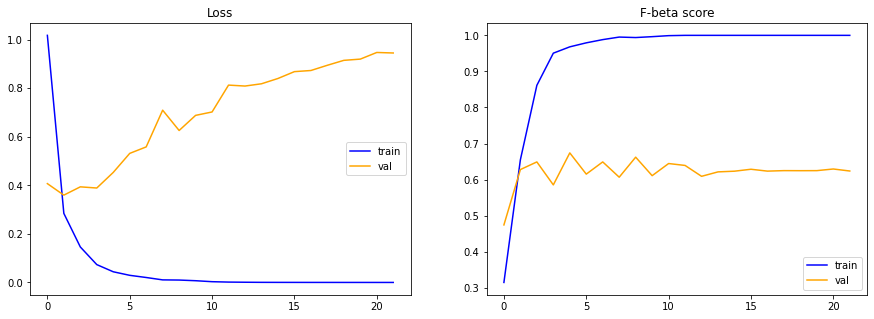

Model F-beta score :  0.6336994767189026


In [ ]:
baseline1_perf = evaluate_model(history)

Note : overfitting

### Baseline model 2 : 2 vgg blocks

Epoch 1/200
64/64 [==============================] - 5s 64ms/step - loss: 0.8344 - fbeta: 0.3389 - val_loss: 0.4634 - val_fbeta: 0.4210
Epoch 2/200
64/64 [==============================] - 4s 58ms/step - loss: 0.3702 - fbeta: 0.5296 - val_loss: 0.3686 - val_fbeta: 0.5652
Epoch 3/200
64/64 [==============================] - 4s 60ms/step - loss: 0.3109 - fbeta: 0.6424 - val_loss: 0.3902 - val_fbeta: 0.5777
Epoch 4/200
64/64 [==============================] - 4s 58ms/step - loss: 0.2377 - fbeta: 0.7630 - val_loss: 0.4264 - val_fbeta: 0.5805
Epoch 5/200
64/64 [==============================] - 4s 59ms/step - loss: 0.1724 - fbeta: 0.8383 - val_loss: 0.4119 - val_fbeta: 0.6221
Epoch 6/200
64/64 [==============================] - 4s 59ms/step - loss: 0.1129 - fbeta: 0.9087 - val_loss: 0.5181 - val_fbeta: 0.6052
Epoch 7/200
64/64 [==============================] - 4s 58ms/step - loss: 0.0831 - fbeta: 0.9332 - val_loss: 0.5783 - val_fbeta: 0.6450
Epoch 8/200
64/64 [=============================

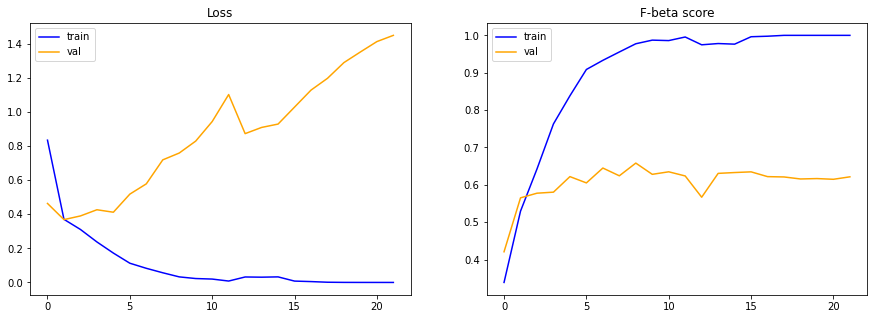

Model F-beta score :  0.6632035970687866


In [ ]:
# create image data generator
train_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_gen = ImageDataGenerator(rescale=1./255)

batch_size = 20
train_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='training', seed=123)
val_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='validation', seed=123)
test_iter = test_gen.flow(X_test, y_test, batch_size=1, seed=123)

# create model
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128, 128, 3)))
model.add(Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128, 128, 3)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='sigmoid'))

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es],
                    epochs=200)
# show result
baseline2_perf = evaluate_model(history)

Note : overfitting

### Baseline model 3 : 3 vgg blocks

Epoch 1/200
64/64 [==============================] - 6s 74ms/step - loss: 0.5403 - fbeta: 0.3632 - val_loss: 0.3736 - val_fbeta: 0.5128
Epoch 2/200
64/64 [==============================] - 4s 70ms/step - loss: 0.3622 - fbeta: 0.5783 - val_loss: 0.3873 - val_fbeta: 0.4890
Epoch 3/200
64/64 [==============================] - 4s 70ms/step - loss: 0.3306 - fbeta: 0.6394 - val_loss: 0.3571 - val_fbeta: 0.5911
Epoch 4/200
64/64 [==============================] - 4s 69ms/step - loss: 0.3134 - fbeta: 0.6534 - val_loss: 0.3556 - val_fbeta: 0.6021
Epoch 5/200
64/64 [==============================] - 4s 69ms/step - loss: 0.2817 - fbeta: 0.7050 - val_loss: 0.3306 - val_fbeta: 0.6576
Epoch 6/200
64/64 [==============================] - 4s 69ms/step - loss: 0.2528 - fbeta: 0.7451 - val_loss: 0.3535 - val_fbeta: 0.6510
Epoch 7/200
64/64 [==============================] - 4s 70ms/step - loss: 0.1926 - fbeta: 0.8107 - val_loss: 0.3934 - val_fbeta: 0.6800
Epoch 8/200
64/64 [=============================

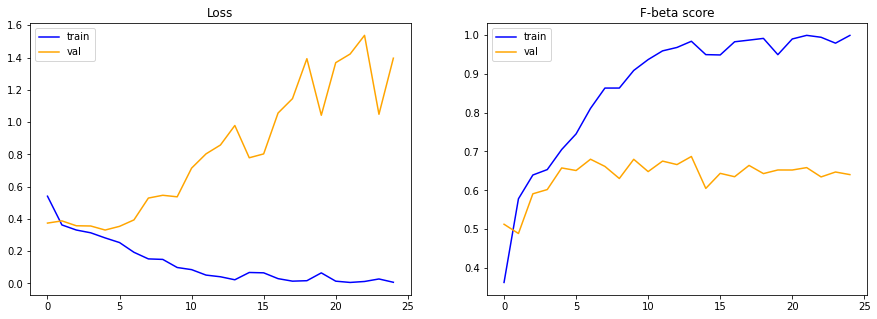

Model F-beta score :  0.6379187107086182


In [ ]:
# create model
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128, 128, 3)))
model.add(Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128, 128, 3)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128, 128, 3)))
model.add(Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='sigmoid'))

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es],
                    epochs=200)
# show result
baseline3_perf = evaluate_model(history)

Note : overfitting

## Baseline model performance


In [ ]:
print('Baseline model 1 : ', baseline1_perf)
print('Baseline model 2 : ', baseline2_perf)
print('Baseline model 3 : ', baseline3_perf)

Baseline model 1 :  0.6336994767189026
Baseline model 2 :  0.6632035970687866
Baseline model 3 :  0.6379187107086182


## Improved Models

### model 1 : Baseline 2 + dropout layers

Epoch 1/200
64/64 [==============================] - 5s 67ms/step - loss: 0.8098 - fbeta: 0.2040 - val_loss: 0.4419 - val_fbeta: 0.3571
Epoch 2/200
64/64 [==============================] - 4s 61ms/step - loss: 0.4310 - fbeta: 0.4469 - val_loss: 0.4002 - val_fbeta: 0.5173
Epoch 3/200
64/64 [==============================] - 4s 61ms/step - loss: 0.4135 - fbeta: 0.4787 - val_loss: 0.3759 - val_fbeta: 0.5427
Epoch 4/200
64/64 [==============================] - 4s 62ms/step - loss: 0.3669 - fbeta: 0.5918 - val_loss: 0.3482 - val_fbeta: 0.5863
Epoch 5/200
64/64 [==============================] - 4s 60ms/step - loss: 0.3483 - fbeta: 0.6025 - val_loss: 0.3503 - val_fbeta: 0.5807
Epoch 6/200
64/64 [==============================] - 4s 61ms/step - loss: 0.3103 - fbeta: 0.6449 - val_loss: 0.3386 - val_fbeta: 0.6203
Epoch 7/200
64/64 [==============================] - 4s 60ms/step - loss: 0.2822 - fbeta: 0.7163 - val_loss: 0.3378 - val_fbeta: 0.6036
Epoch 8/200
64/64 [=============================

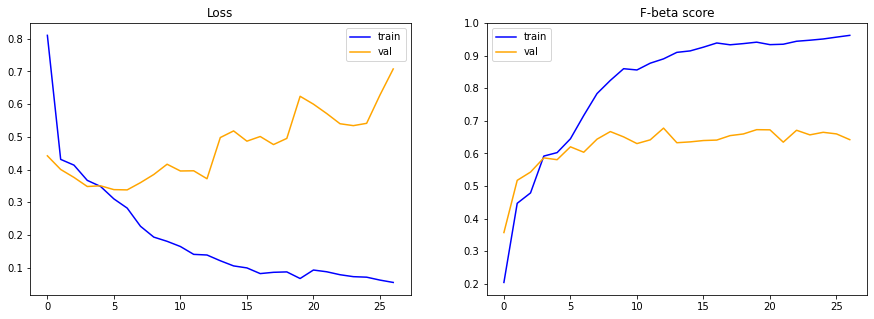

Model F-beta score :  0.614126980304718


In [ ]:
# create image data generator
train_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_gen = ImageDataGenerator(rescale=1./255)

batch_size = 20
train_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='training', seed=123)
val_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='validation', seed=123)
test_iter = test_gen.flow(X_test, y_test, batch_size=1, shuffle=False)

# create model
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128, 128, 3)))
model.add(Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128, 128, 3)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.3))
model.add(Dense(5, activation='sigmoid'))

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es],
                    epochs=200)
# show result
model1_perf = evaluate_model(history)

Note : overfitting

### model 2 : Baseline 2 + data augmentation

Epoch 1/200
64/64 [==============================] - 9s 135ms/step - loss: 0.7195 - fbeta: 0.2359 - val_loss: 0.4384 - val_fbeta: 0.3472
Epoch 2/200
64/64 [==============================] - 8s 129ms/step - loss: 0.4205 - fbeta: 0.3985 - val_loss: 0.3977 - val_fbeta: 0.4675
Epoch 3/200
64/64 [==============================] - 8s 129ms/step - loss: 0.3983 - fbeta: 0.4871 - val_loss: 0.4131 - val_fbeta: 0.4564
Epoch 4/200
64/64 [==============================] - 8s 129ms/step - loss: 0.3857 - fbeta: 0.5033 - val_loss: 0.3999 - val_fbeta: 0.5449
Epoch 5/200
64/64 [==============================] - 8s 128ms/step - loss: 0.3774 - fbeta: 0.5536 - val_loss: 0.3854 - val_fbeta: 0.5170
Epoch 6/200
64/64 [==============================] - 8s 127ms/step - loss: 0.3760 - fbeta: 0.5334 - val_loss: 0.3770 - val_fbeta: 0.5302
Epoch 7/200
64/64 [==============================] - 8s 126ms/step - loss: 0.3631 - fbeta: 0.5657 - val_loss: 0.3783 - val_fbeta: 0.5481
Epoch 8/200
64/64 [======================

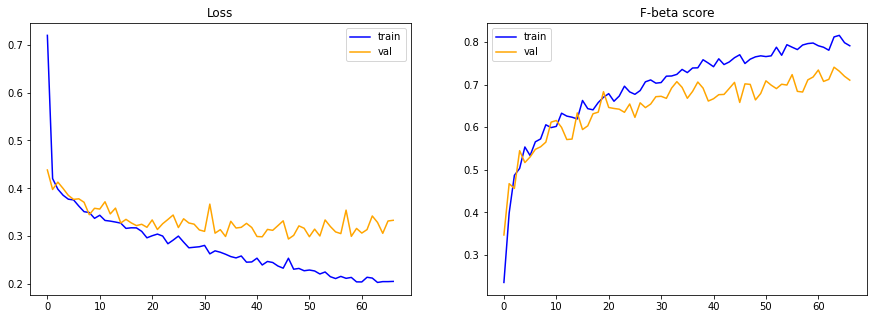

Model F-beta score :  0.7444949150085449


In [ ]:
# create data generator with data augmentation
train_gen = ImageDataGenerator(rescale=1./255,
                               rotation_range=30,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               vertical_flip=True,
                               validation_split=0.2)
test_gen = ImageDataGenerator(rescale=1./255)

batch_size = 20
train_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='training', seed=123)
val_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='validation', seed=123)
test_iter = test_gen.flow(X_test, y_test, batch_size=1, shuffle=False)

# create model
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128, 128, 3)))
model.add(Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128, 128, 3)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='sigmoid'))

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es],
                    epochs=200)
# show result
model2_perf = evaluate_model(history)

Note : overfitting is reduced

### model 3 : Baseline 2 + data augmentation + dropout layers

Epoch 1/200
64/64 [==============================] - 10s 136ms/step - loss: 0.7466 - fbeta: 0.1084 - val_loss: 0.5217 - val_fbeta: 0.1628
Epoch 2/200
64/64 [==============================] - 8s 130ms/step - loss: 0.5165 - fbeta: 0.1873 - val_loss: 0.4580 - val_fbeta: 0.2753
Epoch 3/200
64/64 [==============================] - 8s 128ms/step - loss: 0.4691 - fbeta: 0.2956 - val_loss: 0.4216 - val_fbeta: 0.2724
Epoch 4/200
64/64 [==============================] - 8s 129ms/step - loss: 0.4502 - fbeta: 0.3695 - val_loss: 0.4424 - val_fbeta: 0.3885
Epoch 5/200
64/64 [==============================] - 8s 129ms/step - loss: 0.4369 - fbeta: 0.4095 - val_loss: 0.3988 - val_fbeta: 0.4630
Epoch 6/200
64/64 [==============================] - 8s 125ms/step - loss: 0.4182 - fbeta: 0.4479 - val_loss: 0.3945 - val_fbeta: 0.4642
Epoch 7/200
64/64 [==============================] - 8s 126ms/step - loss: 0.4051 - fbeta: 0.4772 - val_loss: 0.3829 - val_fbeta: 0.5373
Epoch 8/200
64/64 [=====================

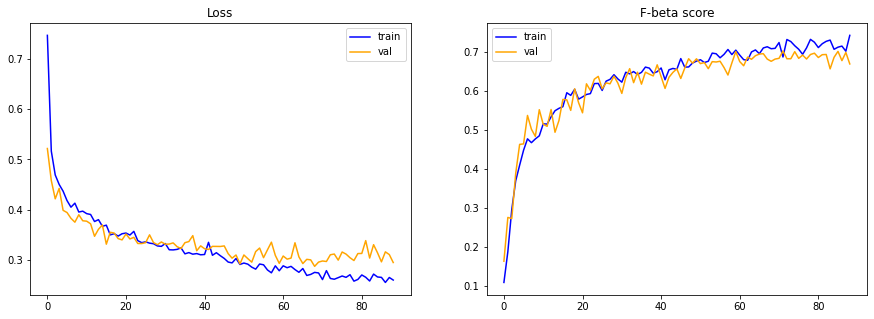

Model F-beta score :  0.6908027529716492


In [ ]:
# create data generator with data augmentation
train_gen = ImageDataGenerator(rescale=1./255,
                               rotation_range=30,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               vertical_flip=True,
                               validation_split=0.2)
test_gen = ImageDataGenerator(rescale=1./255)

batch_size = 20
train_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='training', seed=123)
val_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='validation', seed=123)
test_iter = test_gen.flow(X_test, y_test, batch_size=1, seed=123)

# create model : add dropout layers
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128, 128, 3)))
model.add(Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128, 128, 3)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.3))
model.add(Dense(5, activation='sigmoid'))

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es],
                    epochs=200)
# show result
model3_perf = evaluate_model(history)

Note : overfitting is reduced, the performance is lower

### model 4 : Baseline 2 + data augmentation + dropout layer + more dense layers

Epoch 1/200
64/64 [==============================] - 9s 132ms/step - loss: 1.1869 - fbeta: 0.1387 - val_loss: 0.5490 - val_fbeta: 0.0000e+00
Epoch 2/200
64/64 [==============================] - 8s 127ms/step - loss: 0.5161 - fbeta: 0.1769 - val_loss: 0.4700 - val_fbeta: 0.2331
Epoch 3/200
64/64 [==============================] - 8s 127ms/step - loss: 0.4891 - fbeta: 0.2870 - val_loss: 0.4799 - val_fbeta: 0.2095
Epoch 4/200
64/64 [==============================] - 8s 128ms/step - loss: 0.4594 - fbeta: 0.3286 - val_loss: 0.4181 - val_fbeta: 0.3866
Epoch 5/200
64/64 [==============================] - 8s 127ms/step - loss: 0.4441 - fbeta: 0.4035 - val_loss: 0.4181 - val_fbeta: 0.4510
Epoch 6/200
64/64 [==============================] - 8s 127ms/step - loss: 0.4311 - fbeta: 0.3988 - val_loss: 0.4079 - val_fbeta: 0.4699
Epoch 7/200
64/64 [==============================] - 8s 127ms/step - loss: 0.4197 - fbeta: 0.4522 - val_loss: 0.4064 - val_fbeta: 0.4666
Epoch 8/200
64/64 [==================

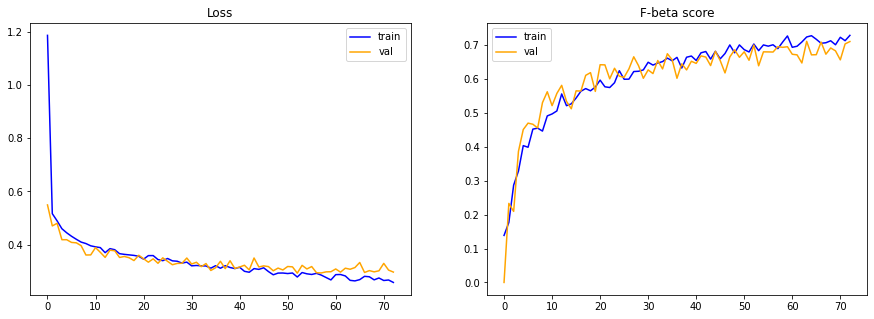

Model F-beta score :  0.6777470111846924


In [ ]:
# create data generator with data augmentation
train_gen = ImageDataGenerator(rescale=1./255,
                               rotation_range=30,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               vertical_flip=True,
                               validation_split=0.2)
test_gen = ImageDataGenerator(rescale=1./255)

batch_size = 20
train_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='training', seed=123)
val_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='validation', seed=123)
test_iter = test_gen.flow(X_test, y_test, batch_size=1, seed=123)

# create model
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128, 128, 3)))
model.add(Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128, 128, 3)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(200, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.3))
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.3))
model.add(Dense(5, activation='sigmoid'))


# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es],
                    epochs=200)
# show result
model4_perf = evaluate_model(history)

### model 5 : Baseline 2 + data augmentation + dropout layer + more dense layers

Epoch 1/200
64/64 [==============================] - 10s 136ms/step - loss: 0.6708 - fbeta: 0.1698 - val_loss: 0.4813 - val_fbeta: 0.2854
Epoch 2/200
64/64 [==============================] - 8s 131ms/step - loss: 0.4830 - fbeta: 0.3071 - val_loss: 0.4436 - val_fbeta: 0.2741
Epoch 3/200
64/64 [==============================] - 8s 131ms/step - loss: 0.4437 - fbeta: 0.3453 - val_loss: 0.4212 - val_fbeta: 0.3300
Epoch 4/200
64/64 [==============================] - 8s 131ms/step - loss: 0.4272 - fbeta: 0.3970 - val_loss: 0.4019 - val_fbeta: 0.4102
Epoch 5/200
64/64 [==============================] - 8s 130ms/step - loss: 0.4105 - fbeta: 0.4424 - val_loss: 0.3884 - val_fbeta: 0.4555
Epoch 6/200
64/64 [==============================] - 8s 130ms/step - loss: 0.3998 - fbeta: 0.4526 - val_loss: 0.3796 - val_fbeta: 0.4451
Epoch 7/200
64/64 [==============================] - 8s 130ms/step - loss: 0.3840 - fbeta: 0.4829 - val_loss: 0.4006 - val_fbeta: 0.4878
Epoch 8/200
64/64 [=====================

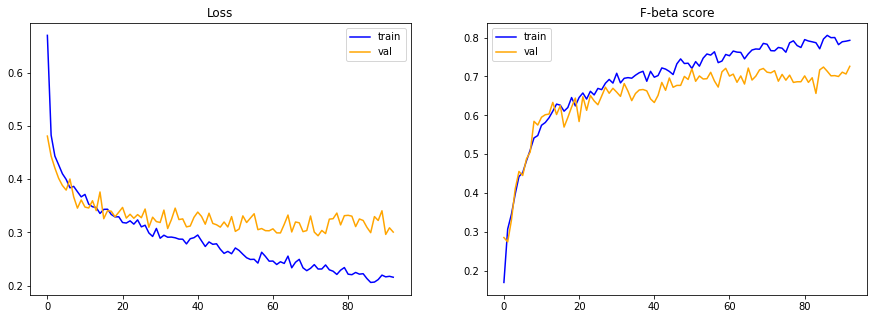

Model F-beta score :  0.7391161322593689


In [ ]:
# create data generator with data augmentation
train_gen = ImageDataGenerator(rescale=1./255,
                               rotation_range=30,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               vertical_flip=True,
                               validation_split=0.2)
test_gen = ImageDataGenerator(rescale=1./255)

batch_size = 20
train_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='training', seed=123)
val_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='validation', seed=123)
test_iter = test_gen.flow(X_test, y_test, batch_size=1, seed=123)

# create model
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128, 128, 3)))
model.add(Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128, 128, 3)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(200, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='sigmoid'))


# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es],
                    epochs=200)
# show result
model5_perf = evaluate_model(history)

## Improved model performance (fbeta score)


In [ ]:
print('Baseline model : ', baseline2_perf)
print('Model 1 : ', model1_perf)
print('Model 2 : ', model2_perf)
print('Model 3 : ', model3_perf)
print('Model 4 : ', model4_perf)
print('Model 5 : ', model5_perf)

Baseline model :  0.6632035970687866
Model 1 :  0.614126980304718
Model 2 :  0.7444949150085449
Model 3 :  0.6908027529716492
Model 4 :  0.6777470111846924
Model 5 :  0.7391161322593689


## Finalize model 2
Train the selected model again.  
Give it more time to learn.  
Save the highest performance with ModelCheckpoint.

Epoch 1/300
64/64 [==============================] - 10s 137ms/step - loss: 0.6870 - fbeta: 0.2431 - val_loss: 0.4555 - val_fbeta: 0.2788

Epoch 00001: val_loss improved from inf to 0.45548, saving model to saved_models/best_vggblocks.h5
Epoch 2/300
64/64 [==============================] - 8s 130ms/step - loss: 0.4295 - fbeta: 0.3625 - val_loss: 0.4090 - val_fbeta: 0.3937

Epoch 00002: val_loss improved from 0.45548 to 0.40897, saving model to saved_models/best_vggblocks.h5
Epoch 3/300
64/64 [==============================] - 8s 129ms/step - loss: 0.3907 - fbeta: 0.4882 - val_loss: 0.3815 - val_fbeta: 0.5970

Epoch 00003: val_loss improved from 0.40897 to 0.38145, saving model to saved_models/best_vggblocks.h5
Epoch 4/300
64/64 [==============================] - 8s 129ms/step - loss: 0.3648 - fbeta: 0.5654 - val_loss: 0.3998 - val_fbeta: 0.4800

Epoch 00004: val_loss did not improve from 0.38145
Epoch 5/300
64/64 [==============================] - 8s 128ms/step - loss: 0.3495 - fbeta: 

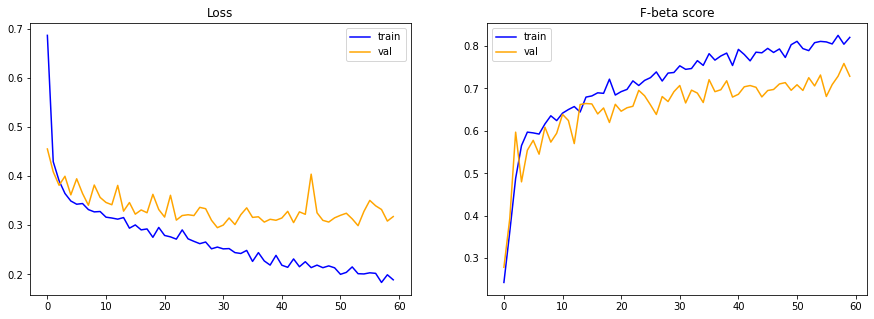

Model F-beta score :  0.7039773464202881


In [ ]:
# create data generator with data augmentation
train_gen = ImageDataGenerator(rescale=1./255,
                               rotation_range=30,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               vertical_flip=True,
                               validation_split=0.2)
test_gen = ImageDataGenerator(rescale=1./255)

batch_size = 20
train_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='training', seed=123)
val_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='validation', seed=123)
test_iter = test_gen.flow(X_test, y_test, batch_size=1, seed=123)

# create model : add dropout layers
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128, 128, 3)))
model.add(Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128, 128, 3)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='sigmoid'))

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

# create model checkpoint to save the model
mc = ModelCheckpoint(model_name, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es, mc],
                    epochs=300)

# show result
fin_model_perf = evaluate_model(history)

## Evaluate model

In [ ]:
# print model score
final_model_fbeta = model.evaluate(test_iter)[1]
print('final_model_fbeta : ', final_model_fbeta)

400/400 [==============================] - 2s 5ms/step - loss: 0.4010 - fbeta: 0.7040
final_model_fbeta :  0.7039772272109985


## Save model to local machine

In [ ]:
# load saved model file to local machine
from google.colab import files
files.download(model_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>